01:36:28 - cmdstanpy - INFO - Chain [1] start processing
01:36:28 - cmdstanpy - INFO - Chain [1] done processing


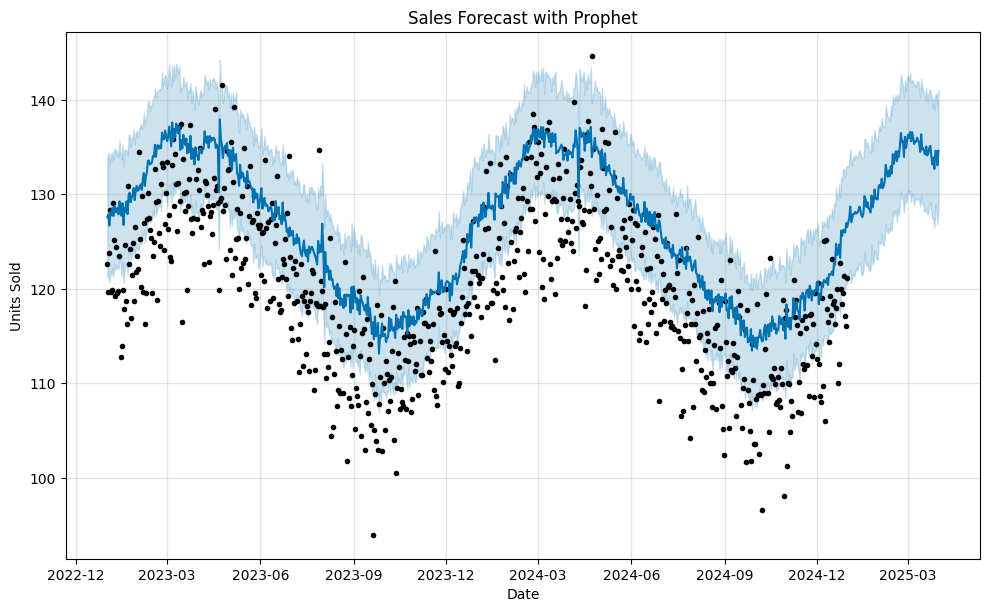

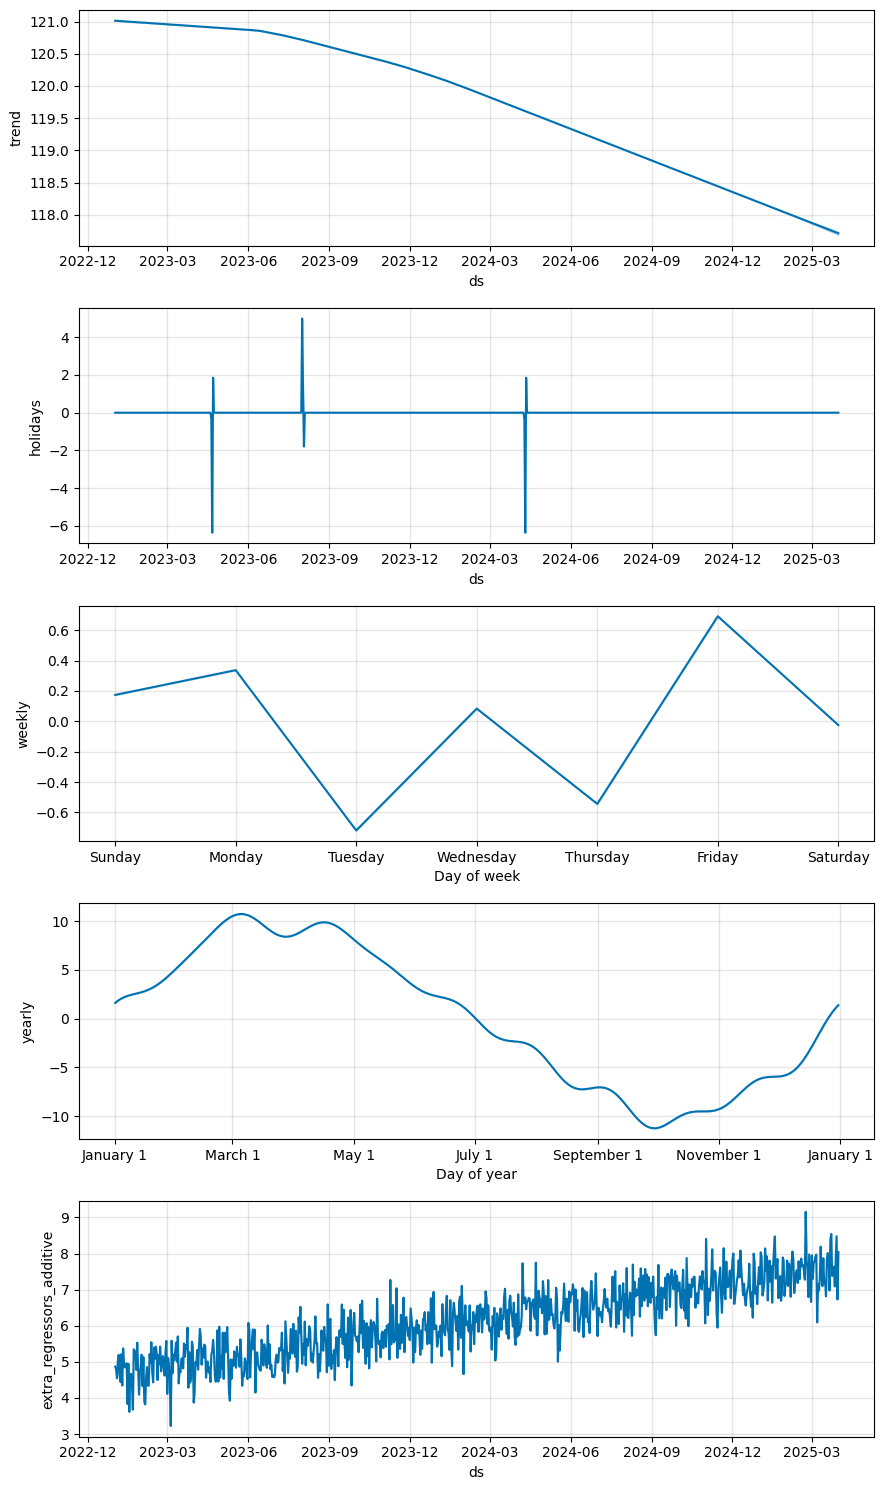


Upcoming Reorder Point (ROP) Estimates:

            ds          ROP
744 2025-01-14  1890.670170
745 2025-01-15  1891.226300
746 2025-01-16  1891.781100
747 2025-01-17  1892.882359
748 2025-01-18  1895.384526
749 2025-01-19  1896.572699
750 2025-01-20  1897.784303
751 2025-01-21  1898.408607
752 2025-01-22  1898.639612
753 2025-01-23  1898.744959


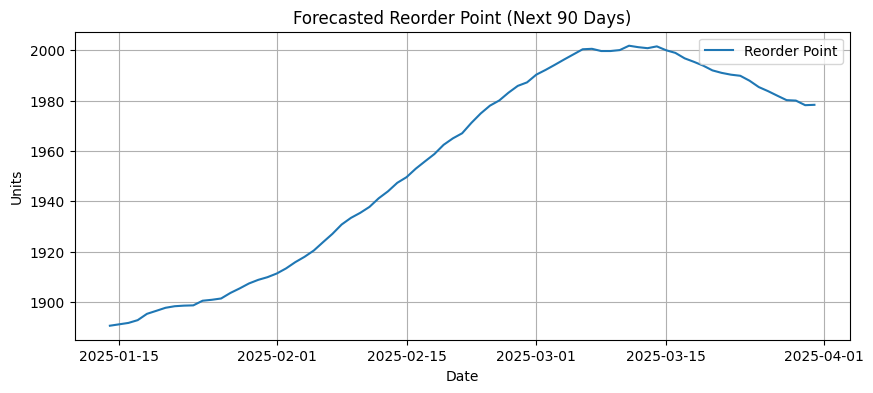

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

# ------------------------------
# 1. Load or Simulate Data
# ------------------------------

# Simulated daily sales data (2 years)
np.random.seed(42)
date_range = pd.date_range(start='2023-01-01', end='2024-12-31', freq='D')
data = pd.DataFrame({
    'ds': date_range,
    'y': 120 + 10 * np.sin(2 * np.pi * date_range.dayofyear / 365) + 5 * np.random.randn(len(date_range)),
    'marketing_spend': 1000 + 100 * np.random.randn(len(date_range)),
    'doctor_visits': 500 + 30 * np.random.randn(len(date_range)),
    'disease_trend': 300 + 20 * np.sin(2 * np.pi * date_range.dayofyear / 180) + 10 * np.random.randn(len(date_range)),
    'stock_level': 10000 - np.cumsum(np.random.poisson(3, len(date_range)))
})

# Clean up data
data['y'] = data['y'].clip(lower=0)
data['stock_level'] = data['stock_level'].clip(lower=0)

# ------------------------------
# 2. Define Holidays
# ------------------------------

holidays = pd.DataFrame({
    'holiday': ['eid_ul_fitr', 'eid_ul_fitr', 'dengue_awareness'],
    'ds': pd.to_datetime(['2023-04-21', '2024-04-10', '2023-08-01']),
    'lower_window': [-1, -1, 0],
    'upper_window': [1, 1, 2]
})

# ------------------------------
# 3. Prepare Prophet Model
# ------------------------------

model = Prophet(
    holidays=holidays,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

# Add external regressors
model.add_regressor('marketing_spend')
model.add_regressor('doctor_visits')
model.add_regressor('disease_trend')
model.add_regressor('stock_level')

# ------------------------------
# 4. Fit the Model
# ------------------------------

model.fit(data)

# ------------------------------
# 5. Create Future DataFrame
# ------------------------------

future = model.make_future_dataframe(periods=90)  # Forecast next 90 days
# Extend regressors for future (use realistic future plans if available)
future['marketing_spend'] = 1000 + 50 * np.random.randn(len(future))
future['doctor_visits'] = 500 + 20 * np.random.randn(len(future))
future['disease_trend'] = 300 + 10 * np.random.randn(len(future))
future['stock_level'] = 5000 - np.cumsum(np.random.poisson(3, len(future)))

# ------------------------------
# 6. Forecast
# ------------------------------

forecast = model.predict(future)

# ------------------------------
# 7. Visualize Forecast
# ------------------------------

fig1 = model.plot(forecast)
plt.title('Sales Forecast with Prophet')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.show()

fig2 = model.plot_components(forecast)
plt.show()

# ------------------------------
# 8. Calculate Reorder Point (ROP)
# ------------------------------

# Assume lead time and safety stock
LEAD_TIME_DAYS = 14
SAFETY_STOCK = 100

# Extract forecasted yhat (predicted sales)
forecast_future = forecast[forecast['ds'] > data['ds'].max()]
forecast_future = forecast_future[['ds', 'yhat']].copy()

# Compute cumulative demand over lead time
forecast_future['rolling_demand'] = forecast_future['yhat'].rolling(window=LEAD_TIME_DAYS).sum()

# Reorder point = Forecasted demand over lead time + safety stock
forecast_future['ROP'] = forecast_future['rolling_demand'] + SAFETY_STOCK

# Show upcoming ROP recommendations
print("\nUpcoming Reorder Point (ROP) Estimates:\n")
print(forecast_future[['ds', 'ROP']].dropna().head(10))

# Optional: Plot ROP
plt.figure(figsize=(10, 4))
plt.plot(forecast_future['ds'], forecast_future['ROP'], label='Reorder Point')
plt.title('Forecasted Reorder Point (Next 90 Days)')
plt.xlabel('Date')
plt.ylabel('Units')
plt.legend()
plt.grid(True)
plt.show()
